#### Colab setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd "gdrive/My Drive/Colab Notebooks"

/content/gdrive/My Drive/Colab Notebooks


#### Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [3]:
import common
import prune
from data import get_mnist, get_cifar
from experiment import Experiment
from models import LeNet_300_100, Conv2

In [4]:
#np.random.seed(common.SEED)
#torch.manual_seed(common.SEED)

In [5]:
pruning_methods = [prune.max_fp_pruning, prune.min_fp_pruning, prune.max_mag_pruning, prune.min_mag_pruning]

In [21]:
def compare_pruning(experiment, testloader, layer, n_rounds, pruning_ratio, *, save_results=False):
    print("Random pruning experiment:\n")
    exp_acc, _ = prune.random_pruning_rounds(experiment, testloader, layer, n_rounds, 
                                             pruning_ratio, save_results=save_results)
    
    pruning_accuracies = {}
    for pruning in pruning_methods:
        pruning_method = pruning.__name__
        print("Pruning using:", pruning_method)
        e.init_model()
        acc, _ = prune.prune_and_test(experiment, testloader, layer, pruning, 
                                         pruning_ratio, save_results=save_results)
        pruning_accuracies[pruning_method] = acc
    
    return exp_acc, pruning_accuracies

In [20]:
def draw_plot(layer, exp_acc, pruning_accuracies, *, figsize=(25,12), fig_name=""):
    plt.figure(figsize=figsize)
    
    exp_acc = np.array(exp_acc)
    random_accuracies = exp_acc.mean(axis=0)
    random_std_devs = exp_acc.std(axis=0)
    plt.errorbar(range(len(max_fp_acc)), random_accuracies, random_std_devs, linestyle='None', 
                 marker='.', label="random pruning")
    
    for pruning_method, acc in pruning_accuracies.items():
        plt.plot(acc, label=pruning_method)
    
    plt.title("Accuracy after pruning " + layer)
    elem_type = "neurons" if layer[:2] == "fc" else "filters"
    plt.xlabel("Pruned " + elem_type)
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="best")
    
    if fig_name:
        fig_path = os.path.join(common.FIGURE_PATH, fig_name)
        plt.savefig(fig_path)
    else:
        plt.show()

In [8]:
def load_state_dict(model_name):
    model_fname = os.path.join(common.MODEL_PATH, model_name)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    return torch.load(model_fname, map_location=device)

## MNIST / Lenet 300-100-10

### Loading the data

In [9]:
train_batch_size = 16
test_batch_size = 1000

In [10]:
trainloader, testloader, classes = get_mnist(train_batch_size, test_batch_size)

### Training the model

In [9]:
epochs = 1
optim_kwargs = {'lr': 0.003, 'momentum': 0.9}

In [24]:
model = LeNet_300_100()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)
monitored = ['fc1', 'fc2', 'fc3']

In [11]:
test_accuracies, frame_potentials = e.fit(trainloader, testloader, epochs, monitored=monitored, save_results=False)


Test set: Average loss: 2.3126, Accuracy:    981/ 10000 (10%)

Train Epoch:   1 [     0/ 60000 (0%)]	Loss: 2.337830
Train Epoch:   1 [  1600/ 60000 (3%)]	Loss: 1.037263
Train Epoch:   1 [  3200/ 60000 (5%)]	Loss: 0.544723
Train Epoch:   1 [  4800/ 60000 (8%)]	Loss: 0.539840
Train Epoch:   1 [  6400/ 60000 (11%)]	Loss: 0.114307
Train Epoch:   1 [  8000/ 60000 (13%)]	Loss: 0.693016
Train Epoch:   1 [  9600/ 60000 (16%)]	Loss: 0.295936
Train Epoch:   1 [ 11200/ 60000 (19%)]	Loss: 0.807158
Train Epoch:   1 [ 12800/ 60000 (21%)]	Loss: 0.450109
Train Epoch:   1 [ 14400/ 60000 (24%)]	Loss: 0.319137
Train Epoch:   1 [ 16000/ 60000 (27%)]	Loss: 0.201430
Train Epoch:   1 [ 17600/ 60000 (29%)]	Loss: 0.146972
Train Epoch:   1 [ 19200/ 60000 (32%)]	Loss: 0.137840
Train Epoch:   1 [ 20800/ 60000 (35%)]	Loss: 0.084311
Train Epoch:   1 [ 22400/ 60000 (37%)]	Loss: 0.179390
Train Epoch:   1 [ 24000/ 60000 (40%)]	Loss: 0.074104
Train Epoch:   1 [ 25600/ 60000 (43%)]	Loss: 0.099241
Train Epoch:   1 [ 272

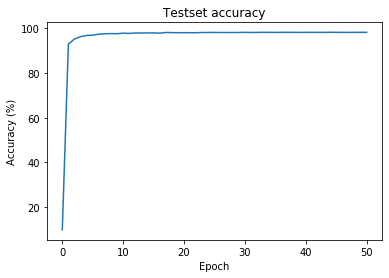

In [0]:
plt.plot(test_accuracies)
plt.title('Testset accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

[Text(0, 0.5, 'FP'), Text(0.5, 0, 'epoch')]

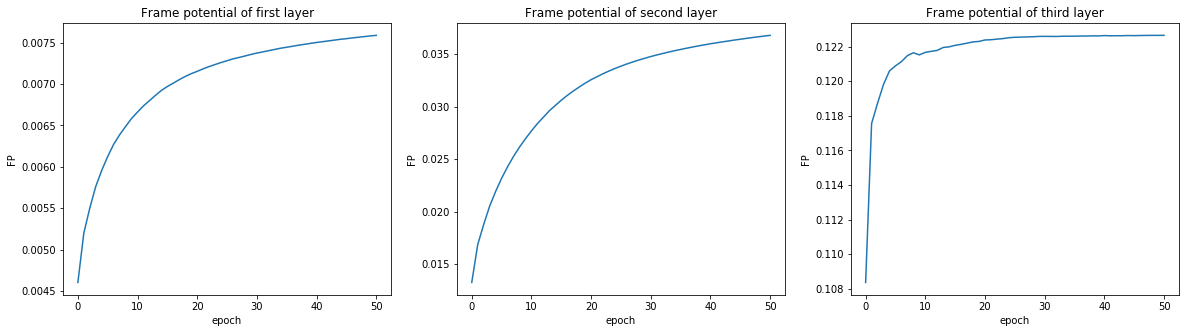

In [0]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, figsize=(20,5))
ax1.plot(frame_potentials['fc1'])
ax1.set_title('Frame potential of first layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(frame_potentials['fc2'])
ax2.set_title('Frame potential of second layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(frame_potentials['fc3'])
ax3.set_title('Frame potential of third layer')
ax3.set(xlabel='epoch', ylabel='FP')

### Pruning LeNet-300-100

#### Pruning the first fully connected layer

In [11]:
model_name = "LeNet_300_100_01-10-2019_10:13:45"
optim_kwargs = {'lr': 0.003, 'momentum': 0.9}
layer = "fc1"
n_rounds = 3
pruning_ratio = 0.2

In [12]:
model = LeNet_300_100()
model_state = load_state_dict(model_name)
model.load_state_dict(model_state)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs, model_state=model_state)
exp_acc, pruning_accuracies = compare_pruning(e, testloader, layer, n_rounds, pruning_ratio, save_results=False)

Random pruning experiment:

Pruning using: max_fp_pruning

Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0746, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9823/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9823/ 10000 (98%)


Test set: Average loss: 0.0748, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0748, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0749, Accuracy:   9823/ 10000 (98%)

Pruning round: [ 10/ 60 (17%)]

Test set: Average loss: 0.0748, Accuracy:   9819/ 10000 (98%)


Test set: Average loss: 0.0746, Accuracy:   9819/ 10000 (98%)


Test set: Average loss: 0.0745, Accuracy:   9819/ 10000 (98%)


Test set: Aver


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0749, Accuracy:   9823/ 10000 (98%)


Test set: Average loss: 0.0749, Accuracy:   9823/ 10000 (98%)


Test set: Average loss: 0.0748, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0748, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0746, Accuracy:   9824/ 10000 (98%)


Test set: Average loss: 0.0746, Accuracy:   9824/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9824/ 10000 (98%)

Pruning round: [ 10/ 60 (17%)]

Test set: Average loss: 0.0745, Accuracy:   9824/ 10000 (98%)


Test set: Average loss: 0.0746, Accuracy:   9823/ 10000 (98%)


Test set: Average loss: 0.0745, Accuracy:   9823/ 10000 (98%)


Test set: Average loss: 0.0745, Accuracy:   9822/ 10000 (98%)


Test set

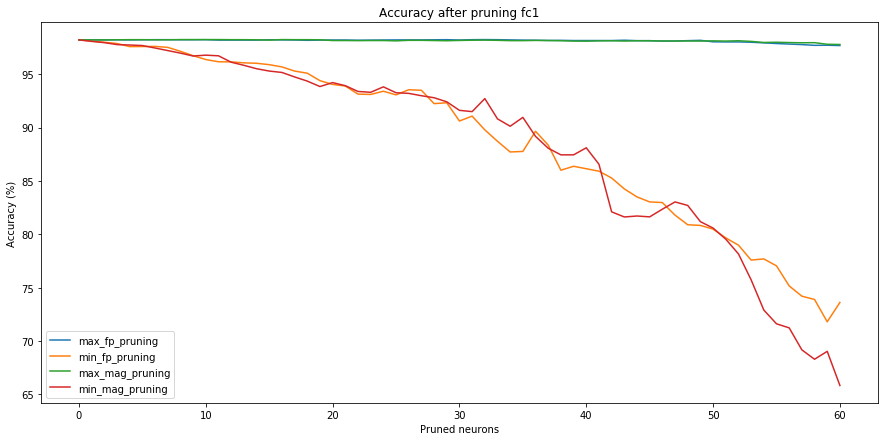

In [19]:
draw_plot(layer, exp_acc, pruning_accuracies, figsize=(15,7), fig_name="")

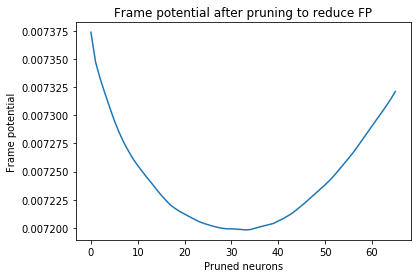

In [0]:
plt.plot(frame_potentials['fc1'])
plt.title('Frame potential after pruning to reduce FP')
plt.xlabel('Pruned neurons')
plt.ylabel('Frame potential')
plt.show()

#### Pruning schedules

In [ ]:
epochs = 1
optim_kwargs = {'lr': 0.003, 'momentum': 0.9}

In [ ]:
model = LeNet_300_100()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)

In [14]:
test_interval = 25
saving_times = [10]
layer = 'fc1'
pruning_ratio = 0.4

In [15]:
trainable, accuracies = prune.pruning_schedule(e, trainloader, testloader, epochs, test_interval, saving_times, layer, pruning_ratio)


Test set: Average loss: 2.3115, Accuracy:    984/ 10000 (10%)

Evaluating model accuracies [  1/150]

Test set: Average loss: 2.1598, Accuracy:   4046/ 10000 (40%)

Evaluating model accuracies [  2/150]

Test set: Average loss: 1.8388, Accuracy:   6111/ 10000 (61%)

Evaluating model accuracies [  3/150]

Test set: Average loss: 1.3559, Accuracy:   6675/ 10000 (67%)

Evaluating model accuracies [  4/150]

Test set: Average loss: 0.9443, Accuracy:   7680/ 10000 (77%)

Evaluating model accuracies [  5/150]

Test set: Average loss: 0.6800, Accuracy:   8247/ 10000 (82%)

Evaluating model accuracies [  6/150]

Test set: Average loss: 0.6233, Accuracy:   8160/ 10000 (82%)

Evaluating model accuracies [  7/150]

Test set: Average loss: 0.5549, Accuracy:   8272/ 10000 (83%)

Evaluating model accuracies [  8/150]

Test set: Average loss: 0.4998, Accuracy:   8478/ 10000 (85%)

Evaluating model accuracies [  9/150]

Test set: Average loss: 0.4883, Accuracy:   8513/ 10000 (85%)

Evaluating model a


Test set: Average loss: 0.2734, Accuracy:   9161/ 10000 (92%)

Evaluating model accuracies [ 54/150]

Test set: Average loss: 0.2319, Accuracy:   9272/ 10000 (93%)


Test set: Average loss: 0.2419, Accuracy:   9246/ 10000 (92%)

Evaluating model accuracies [ 55/150]

Test set: Average loss: 0.2154, Accuracy:   9349/ 10000 (93%)


Test set: Average loss: 0.2299, Accuracy:   9297/ 10000 (93%)

Evaluating model accuracies [ 56/150]

Test set: Average loss: 0.2297, Accuracy:   9305/ 10000 (93%)


Test set: Average loss: 0.2433, Accuracy:   9268/ 10000 (93%)

Evaluating model accuracies [ 57/150]

Test set: Average loss: 0.2424, Accuracy:   9256/ 10000 (93%)


Test set: Average loss: 0.2480, Accuracy:   9218/ 10000 (92%)

Evaluating model accuracies [ 58/150]

Test set: Average loss: 0.2175, Accuracy:   9350/ 10000 (94%)


Test set: Average loss: 0.2306, Accuracy:   9310/ 10000 (93%)

Evaluating model accuracies [ 59/150]

Test set: Average loss: 0.1992, Accuracy:   9394/ 10000 (94%)


Tes


Test set: Average loss: 0.1514, Accuracy:   9523/ 10000 (95%)


Test set: Average loss: 0.1611, Accuracy:   9507/ 10000 (95%)

Evaluating model accuracies [104/150]

Test set: Average loss: 0.1750, Accuracy:   9427/ 10000 (94%)


Test set: Average loss: 0.1850, Accuracy:   9388/ 10000 (94%)

Evaluating model accuracies [105/150]

Test set: Average loss: 0.1526, Accuracy:   9541/ 10000 (95%)


Test set: Average loss: 0.1584, Accuracy:   9521/ 10000 (95%)

Evaluating model accuracies [106/150]

Test set: Average loss: 0.1752, Accuracy:   9440/ 10000 (94%)


Test set: Average loss: 0.1881, Accuracy:   9403/ 10000 (94%)

Evaluating model accuracies [107/150]

Test set: Average loss: 0.1610, Accuracy:   9499/ 10000 (95%)


Test set: Average loss: 0.1665, Accuracy:   9474/ 10000 (95%)

Evaluating model accuracies [108/150]

Test set: Average loss: 0.2030, Accuracy:   9361/ 10000 (94%)


Test set: Average loss: 0.2140, Accuracy:   9314/ 10000 (93%)

Evaluating model accuracies [109/150]

Tes

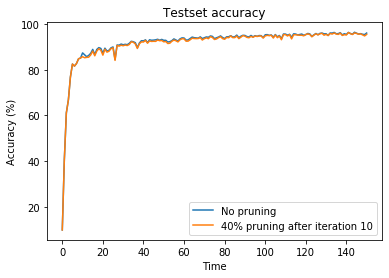

In [19]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[10], label="40% pruning after iteration 10")
plt.title('Testset accuracy')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

### Show images, compare class results

In [0]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [0]:
print(images.shape)
print(labels.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \n', ' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: \n', ' '.join('%9s' % classes[predicted[j]]
                              for j in range(4)))

Predicted: 
         7         2         1         0


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 98 %
Accuracy of 1 : 97 %
Accuracy of 2 : 89 %
Accuracy of 3 : 96 %
Accuracy of 4 : 100 %
Accuracy of 5 : 92 %
Accuracy of 6 : 94 %
Accuracy of 7 : 96 %
Accuracy of 8 : 98 %
Accuracy of 9 : 97 %


## CIFAR-10 / Conv-2

### Loading the data

In [36]:
train_batch_size = 64
test_batch_size = 1000

In [37]:
trainloader, testloader, classes = get_cifar(train_batch_size, test_batch_size)

Files already downloaded and verified
Files already downloaded and verified


### Training the model

In [43]:
epochs = 1
optim_kwargs = {'lr': 0.0002}

In [44]:
model = Conv2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)
monitored = ['conv1', 'conv2', 'fc1', 'fc2']

In [45]:
test_accuracies, frame_potentials = e.fit(trainloader, testloader, epochs, monitored=monitored, save_results=False)


Test set: Average loss: 2.3040, Accuracy:   1196/ 10000 (12%)

Train Epoch:   1 [     0/ 50000 (0%)]	Loss: 2.303413
Train Epoch:   1 [  6400/ 50000 (13%)]	Loss: 1.696310
Train Epoch:   1 [ 12800/ 50000 (26%)]	Loss: 1.375621
Train Epoch:   1 [ 19200/ 50000 (38%)]	Loss: 1.520925
Train Epoch:   1 [ 25600/ 50000 (51%)]	Loss: 1.180210
Train Epoch:   1 [ 32000/ 50000 (64%)]	Loss: 1.449784
Train Epoch:   1 [ 38400/ 50000 (77%)]	Loss: 1.393945
Train Epoch:   1 [ 44800/ 50000 (90%)]	Loss: 1.346639

Test set: Average loss: 1.1910, Accuracy:   5845/ 10000 (58%)



In [0]:
test_accuracies, frame_potentials = e.fit(trainloader, testloader, epochs, monitored=monitored, save_results=False)


Test set: Average loss: 2.3042, Accuracy:    990/ 10000 (10%)

Train Epoch:   1 [     0/ 50000 (0%)]	Loss: 2.309030
Train Epoch:   1 [  6400/ 50000 (13%)]	Loss: 1.742888
Train Epoch:   1 [ 12800/ 50000 (26%)]	Loss: 1.389441
Train Epoch:   1 [ 19200/ 50000 (38%)]	Loss: 1.221832
Train Epoch:   1 [ 25600/ 50000 (51%)]	Loss: 1.265922
Train Epoch:   1 [ 32000/ 50000 (64%)]	Loss: 1.124998
Train Epoch:   1 [ 38400/ 50000 (77%)]	Loss: 1.327337
Train Epoch:   1 [ 44800/ 50000 (90%)]	Loss: 1.221110

Test set: Average loss: 1.1754, Accuracy:   5812/ 10000 (58%)

Train Epoch:   2 [     0/ 50000 (0%)]	Loss: 1.117527
Train Epoch:   2 [  6400/ 50000 (13%)]	Loss: 0.990872
Train Epoch:   2 [ 12800/ 50000 (26%)]	Loss: 1.152403
Train Epoch:   2 [ 19200/ 50000 (38%)]	Loss: 0.908521
Train Epoch:   2 [ 25600/ 50000 (51%)]	Loss: 1.022519
Train Epoch:   2 [ 32000/ 50000 (64%)]	Loss: 0.883264
Train Epoch:   2 [ 38400/ 50000 (77%)]	Loss: 0.807983
Train Epoch:   2 [ 44800/ 50000 (90%)]	Loss: 0.735661

Test set:

[Text(0, 0.5, 'FP'), Text(0.5, 0, 'epoch')]

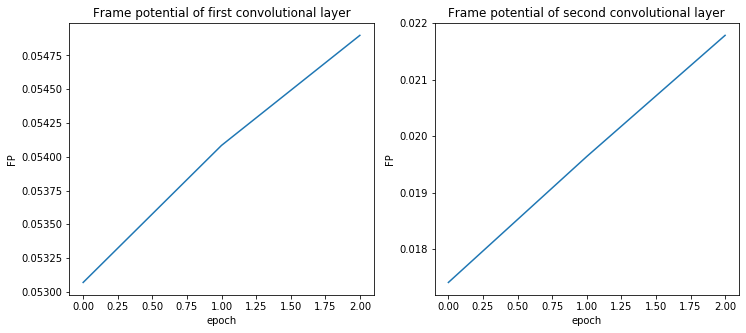

In [0]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, sharex=True, figsize=(12,5))
ax1.plot(frame_potentials['conv1'])
ax1.set_title('Frame potential of first convolutional layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(frame_potentials['conv2'])
ax2.set_title('Frame potential of second convolutional layer')
ax2.set(xlabel='epoch', ylabel='FP')

### Pruning Conv2

In [49]:
model_name = "Conv2_01-10-2019_12:37:35"
optim_kwargs = {'lr': 0.0002}
n_rounds = 3
pruning_ratio = 0.2

#### Pruning the first fully connected layer

In [ ]:
layer = "fc1"

model = Conv2()
model_state = load_state_dict(model_name)
model.load_state_dict(model_state)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs, model_state=model_state)
exp_acc, pruning_accuracies = compare_pruning(e, testloader, layer, n_rounds, pruning_ratio, save_results=False)

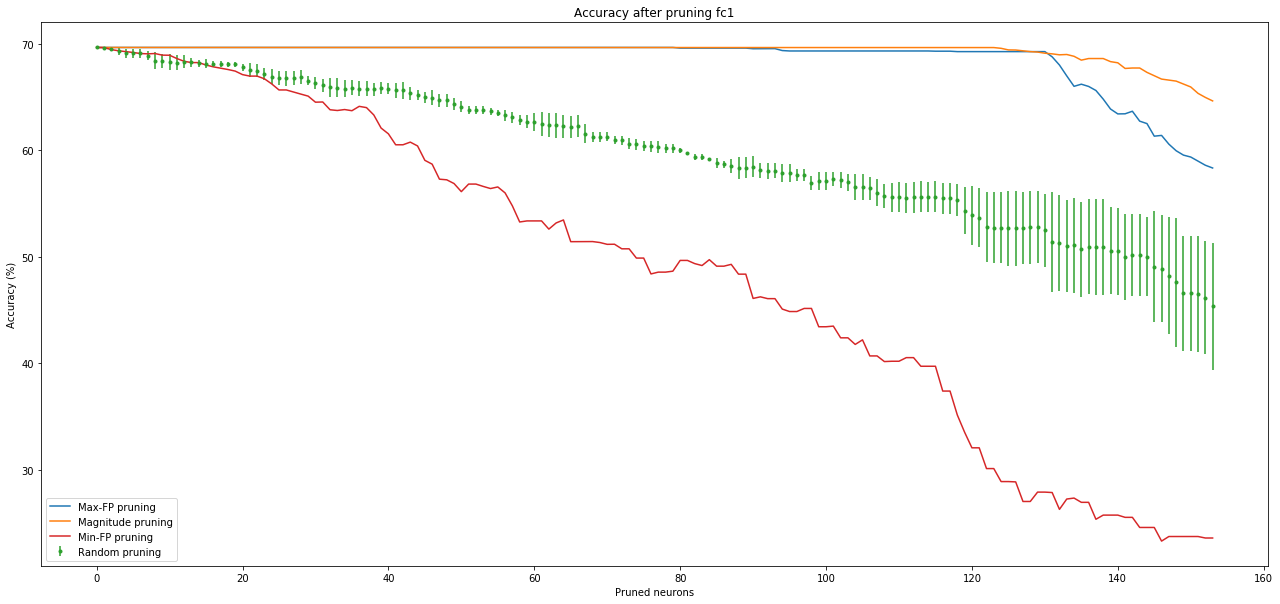

In [14]:
draw_plot(layer, exp_acc, pruning_accuracies, figsize=(22,10), fig_name="")

#### Pruning the first convolutional layer

In [ ]:
layer = "conv1"

model = Conv2()
model_state = load_state_dict(model_name)
model.load_state_dict(model_state)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs, model_state=model_state)
exp_acc, pruning_accuracies = compare_pruning(e, testloader, layer, n_rounds, pruning_ratio, save_results=False)

In [0]:
draw_plot(layer, exp_acc, pruning_accuracies, figsize=(10,5), fig_name="")

#### Pruning schedules

In [53]:
epochs = 1
optim_kwargs = {'lr': 0.0002}

In [54]:
model = Conv2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)

In [55]:
test_interval = 25
saving_times = []
layer = 'fc1'
pruning_ratio = 0.4

In [ ]:
trainable, accuracies = prune.pruning_schedule(e, trainloader, testloader, epochs, test_interval, saving_times, layer, pruning_ratio)

In [ ]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[10], label="40% pruning after iteration 10")
plt.title('Testset accuracy')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

### Show images, compare class results

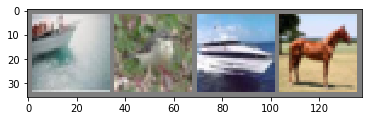

 ship  bird  ship horse


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 69 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 65 %
Accuracy of  bird : 51 %
Accuracy of   cat : 46 %
Accuracy of  deer : 53 %
Accuracy of   dog : 20 %
Accuracy of  frog : 49 %
Accuracy of horse : 59 %
Accuracy of  ship : 79 %
Accuracy of truck : 57 %
